# iXnos Tutorial: Using Trained Models
As part of my rotation project, I've reimplemented the [iXnos](https://www.nature.com/articles/s41594-018-0080-2) architecture + framework for training new iXnos models from ribosome footprinting data. Note that this requires you to preprocess the data using the original Python2 iXnos scripts and a suitable environment; I've detailed the basics of how to do that in `preprocessing.md` (however, I'd recommend checking in with Liana if you plan on processing new datasets yourself). This notebook will walk you through the basic functionality of this implementation of iXnos, as well as how to train new models given pre-processed data. 


*What exactly is iXnos doing?* - iXnos is a simple neural net that predicts scaled counts of ribosomes at a given A site. It does this by taking the codons + nucleotides of the A site in addition to those of some surrounding codons, which you specify wqhen training the model. For instance, a -3 to +2 iXnos model will predict counts based on the A site in addition to the 3 codons before it and 2 codons after it, in addition to using the nucleotides found ion each of those codons. 

*What is scaled count?* - Scaled counts are the measured number of ribosomes detected at a given A site on a transcript, divided by the average number of ribosomes on that transcript (which in turn is the total number of ribosomes detected on that transcript divided by the length of the transcript).

*Why would I want to train new models?* - iXnos is super flexible with respect to which codons around each position it uses to predict ribosome count. Typically, you might tweak which codons to use based on what you're using the model for. For instance, although models trained on the -5 to +4 codons around each A site achieve higher accuracy, if you want to use an iXnos model to design sequences you'd put into cells yourself, it'd likely be best to use a model trained on the -3 to +2 positions since a wider window may be achieving this accuracy largely because of ligation biases at the -5, -4, +3, or +4 positions. 

NOTE: Although the iXnos paper mentions using RNA structure scores as inputs, my implementation *only* uses the codons + nucleotides within the specified window.


In [3]:
# NOTE: Running this will mean you'll save stuff in my directory. 
# Please use this notebook as a general guide and don't run directly :)
# %cd /mnt/lareaulab/demaray/lareau-rotation

/mnt/lareaulab/demaray/lareau-rotation


In [5]:
import pandas as pd
import torch
import numpy as np
import sys
import os
sys.path.append("scripts/")
from ixnos import *
import matplotlib.pyplot as plt
import seaborn as sns

!pwd

/mnt/lareaulab/demaray/lareau-rotation


# Training a New iXnos
Here, I'll show how to train a -3 to +2 iXnos model on some previously processed HEK cell data.

In [107]:
transcripts_filepath = "iXnos/genome_data/human.transcripts.13cds10.transcripts.fa"
data_dir = "iXnos/expts/iwasaki/process"
# Specify a directory to save the models -- this will be created if it doesn't already exist
# NOTE: I like to store models in a models subdirectory to keep things organized
output_dir = "processed-data/tutorial/models"

Let's take a look at some of the input files. First, the transcripts file is a fasta file with transcript names + sequences. This is NOT generated by iXnos!

In [99]:
!head $transcripts_filepath

>ENST00000000233.8
CCCGGGCCCCGCCATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGAAGCAGATGCGGATTCTCATGGTTGGCTTGGATGCGGCTGGCAAGACCACAATCCTGTACAAACTGAAGTTGGGGGAGATTGTCACCACCATCCCAACCATAGGCTTCAATGTAGAAACAGTGGAATATAAGAACATCTGTTTCACAGTCTGGGACGTGGGAGGCCAGGACAAGATTCGGCCTCTGTGGCGGCACTACTTCCAGAACACTCAGGGCCTCATCTTTGTGGTGGACAGTAATGACCGGGAGCGGGTCCAAGAATCTGCTGATGAACTCCAGAAGATGCTGCAGGAGGACGAGCTGCGGGATGCAGTGCTGCTGGTATTTGCCAACAAGCAGGACATGCCCAACGCCATGCCCGTGAGCGAGCTGACTGACAAGCTGGGGCTACAGCACTTACGCAGCCGCACGTGGTATGTCCAGGCCACCTGTGCCACCCAAGGCACAGGTCTGTACGATGGTCTGGACTGGCTGTCCCACGAGCTGTCAAAGCGCTAACCAGCCAGGG
>ENST00000000412.6
TTCCCACGACACGATGTTCCCTTTCTACAGCTGCTGGAGGACTGGACTGCTACTACTACTCCTGGCTGTGGCAGTGAGAGAATCCTGGCAGACAGAAGAAAAAACTTGCGACTTGGTAGGAGAAAAGGGTAAAGAGTCAGAGAAAGAGTTGGCTCTAGTGAAGAGGCTGAAACCACTGTTTAATAAAAGCTTTGAGAGCACTGTGGGCCAGGGTTCAGACACATACATCTACATCTTCAGGGTGTGCCGGGAAGCTGGCAACCACACTTCTGGGGCAGGCCTGGTGCAAATCAACAAAAGTAATGGGAAGGAGACAGTGGTAGGGAGACTCAACGAGACTCACATCTTCAACGGAAGTAATTGGATCATGCTGATCTATAAAGGGGGTGATGAAT

iXnos preprocessing scripts output `data_table.txt` tab-separated files that contain the actual and scaled ribosome count at each A site along each transcript, usually truncating the first and last 20 codons in the CDS to mitigate effects of translation initiation / termination. These are also split into Train and Test sets, with prefixes `tr` or `te`, respectively. 

In [114]:
footprint_data_files = [i for i in os.listdir(f"{data_dir}") if i.endswith("data_table.txt")]
footprint_data_files

['te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt',
 'tr_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt']

In [ ]:
# These files are readable with pandas:
pd.read_csv(f"{data_dir}/{footprint_data_files[0]}", sep="\t").head()

,gene,cod_idx,cod_seq,raw_cts,scaled_cts
0,ENST00000001008.5,20,GAG,0.000000,0.000000
1,ENST00000001008.5,21,GGA,0.000000,0.000000
2,ENST00000001008.5,22,GTG,3.985792,0.353353
3,ENST00000001008.5,23,GAC,7.971626,0.706709
4,ENST00000001008.5,24,ATC,1.992938,0.176680


Now we can run ixnos.py to train a model! Note that if we were doing this in the command line, we'd substitute the `$data_dir` with `iXnos/expts/iwasaki/process`; I'm just using variables here for brevity.

**Required arguments:**
- `-d`: specifies the path to the directory containing your train and test data tables
- `-o`: specifies path to save model to
- `-g`: specifies path to a fasta file containing transcriptome information
- `-n`: index of the leftmost codon to consider. Will be interpreted as negative (i.e. inputs -3 or 3 will both result in the model using -3 as the leftmost codon)
- `-p`: index of the rightmost codon to consider. 
- `-l` (`Optional`): index of the codon to omit from the model. Use this if you want to train a leaveout series to evaluate how much omitting each codon position impacts model perfomance. 

In [120]:
!python scripts/ixnos.py -d $data_dir -o $output_dir -g $transcripts_filepath -n -5 -p 4

Training an iXnos model
	Codon range: -5 to 4
	Leaveout index: None
Using cpu device
Training set: found ['iXnos/expts/iwasaki/process/tr_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt'], using iXnos/expts/iwasaki/process/tr_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt
Test set: found ['iXnos/expts/iwasaki/process/te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt'], using iXnos/expts/iwasaki/process/te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt
Initial | Pearson Correlation: -0.0163 | Test Loss: 5.1560
Epoch 0: Average Loss: 2.8407419706233825 | Learning Rate: 0.009697 | Pearson Correlation: 0.4374 | Test Loss: 3.4870
Epoch 1: Average Loss: 2.642701543039746 | Learning Rate: 0.009412 | Pearson Correlation: 0.4418 | Test Loss: 3.4635
Epoch 2: Average Loss: 2.6189874314298534 | Learning Rate: 0.009143 | Pearson Correlation: 0.4524 | Test Loss: 3.41

Now that we've trained a model, let's read in the results. `ixnos.py` outputs 2 files:
- A `model.pth` file, containing the weights and biases
- a `loss_by_epoch.csv` file, which contains the training loss, test loss, and pearson correlation (between the predicted outputs and the actual scaled counts in the test data) at each epoch. 

In [ ]:
output_model_path = f"{output_dir}/ixnos_n5p4_full.pth"
# Load in the model into a pytorch iXnos object; details on what you can do with this are below
my_model = iXnos(min_codon=-5, max_codon=4)
my_model.load_state_dict(
    torch.load(output_model_path, weights_only=False))
my_model.eval()

iXnos(
  (layers): Sequential(
    (0): Linear(in_features=760, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [128]:
# Load in the loss by epochs and plot results of that
output_loss_path = f"{output_dir}/ixnos_n5p4_full_loss_by_epoch.csv"
loss_by_epoch = pd.read_csv(output_loss_path)
loss_by_epoch.head()

,epoch,loss_tr,loss_te,corr_te
0,0,NaN,5.156015,-0.016350
1,1,2.840742,3.487012,0.437399
2,2,2.642702,3.463545,0.441775
3,3,2.618987,3.412885,0.452376
4,4,2.607711,3.443397,0.451091


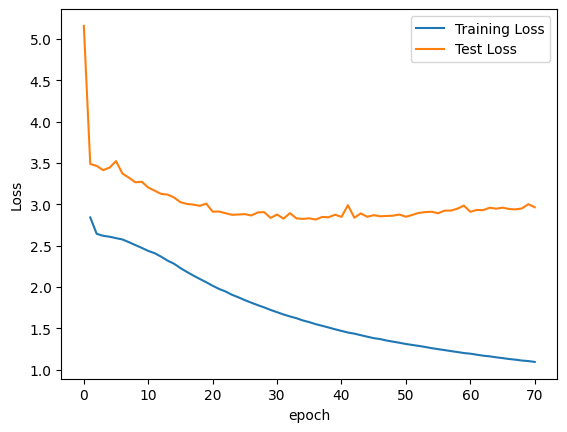

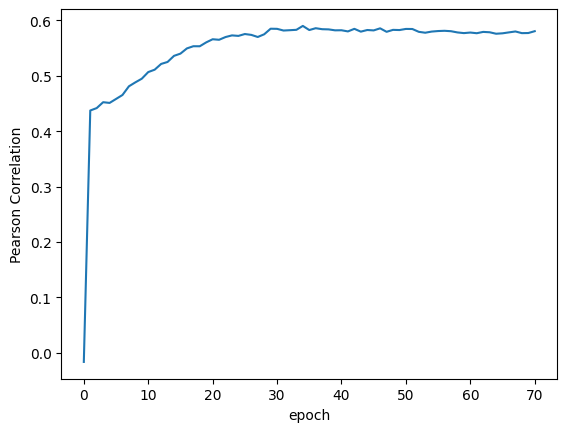

In [134]:
sns.lineplot(loss_by_epoch, x="epoch", y="loss_tr", label="Training Loss")
sns.lineplot(loss_by_epoch, x="epoch", y="loss_te", label="Test Loss")
plt.ylabel("Loss")
plt.legend()
plt.show()

sns.lineplot(loss_by_epoch, x="epoch", y="corr_te")
plt.ylabel("Pearson Correlation")
plt.show()

## Leaveout Series
You can train a series of leave-one-out models that omit one codon (and its nucleotides) from training, and you can evaluate the performance of those models in comparison to the full model using the `loss_by_epoch.csv` files generated for each. 

I usually just run these with a command like this, but ideally you'd run this in parallel:
```for i in {-5..4}; do python scripts/ixnos.py -d $data_dir -o $output_dir -g $transcripts_filepath -n -5 -p 4 -l $i; done```

Here is a bash script that trains a leaveout series for the model above; this took ~70 min to run (not much of a performance increase compared to running in series)

`NOTE`: In general, this tends to be kinda buggy, so if one or more leaveout models appears not to have saved, just retry running that in a single command (e.g. `python scripts/ixnos.py -d $data_dir -o $output_dir -g $transcripts_filepath -n -5 -p 4 -l -1`). 

In [ ]:
%%bash
transcripts_filepath="iXnos/genome_data/human.transcripts.13cds10.transcripts.fa"
data_dir="iXnos/expts/iwasaki/process"
output_dir="processed-data/tutorial/models"

for i in {-5..4}
    # do echo $transcripts_filepath; echo hi
    do python scripts/ixnos.py -d $data_dir -o $output_dir -g $transcripts_filepath -n -5 -p 4 -l $i &
done

I've bundled together some plotting functions I use to evaluate leaveout series in `generate_leaveout_plots`

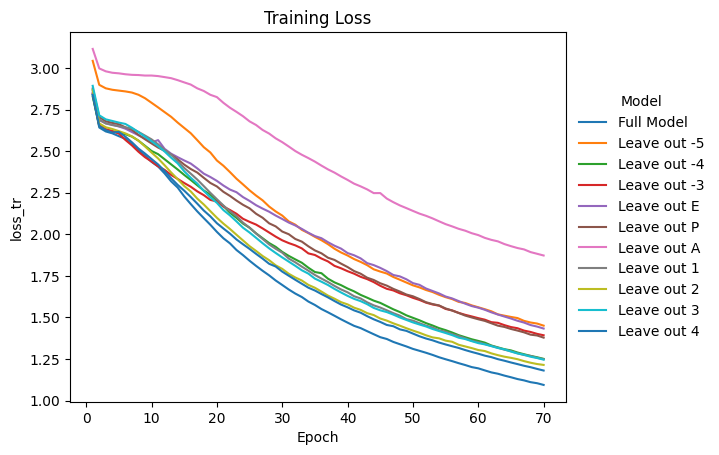

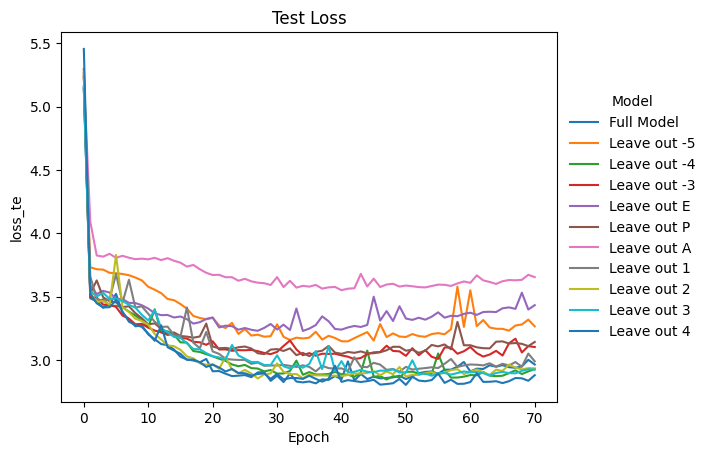

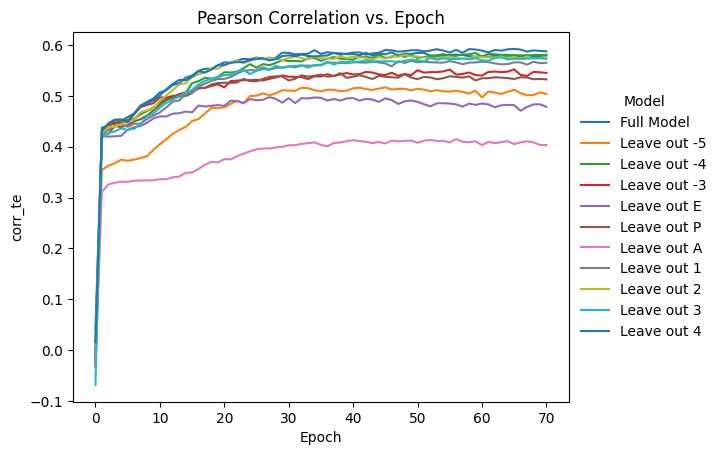

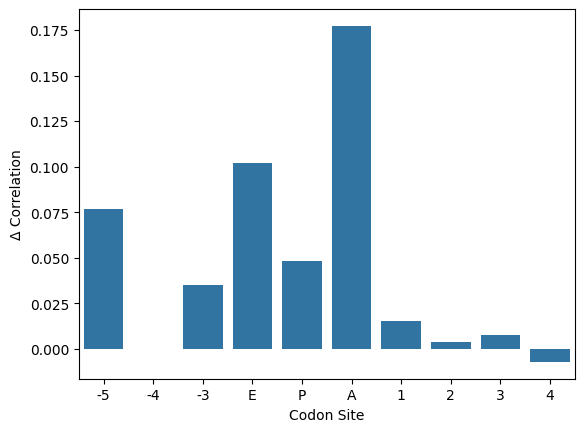

In [190]:
comps = generate_leaveout_plots(output_dir, -5, 4, return_comps=True)

# Using Trained Models
Most of the time, you'll be using models that have already been trained to predict optimal sequences or score sequences for a given protein. 

In [6]:
# Specify path to iXnos model. 
# NOTE: generally, the file names will clue you into the codon indices used. 
# In this case, n3p2 indicates that the model was trained on the -3 to +2 codons. 
model_path = "processed-data/iwasaki/models/ixnos_n3p2_full.pth"
# Initialize an iXnos model that looks at the same indices as the one you want to load
model = iXnos(min_codon=-3, max_codon=2)
# Load the trained weights into the model
model.load_state_dict(
    torch.load(model_path, weights_only=False))
model.eval()

iXnos(
  (layers): Sequential(
    (0): Linear(in_features=456, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [34]:
# Predicting the counts at one A site
# First, I'll generate a random sequence to score
a_site_nhood_codons = np.random.choice(iXnos.get_codons(), 6)
a_site_nhood_nts = "".join(a_site_nhood_codons)
print(f"Sequence: {a_site_nhood_nts}\nCodons: {a_site_nhood_codons}\n"\
      f"A site codon: {a_site_nhood_codons[-3]}")
# We can use the get_inputs function to generate an input tensor we can feed into the model:
input_tensor = model.get_inputs(a_site_nhood_codons)
print(f"Input tensor shape: (1 x {input_tensor.shape[0]})")
# Use the predict function to predict scaled counts for this sequence of codons:
predicted_counts = model.predict(input_tensor).item()
print(f"Predicted Counts: {predicted_counts}")

Sequence: AAAATGTAGACTGGCTAC
Codons: ['AAA' 'ATG' 'TAG' 'ACT' 'GGC' 'TAC']
A site codon: ACT
Input tensor shape: (1 x 456)
Predicted Counts: 0.739772617816925


What if we wanted to predict the total elongation time for a given coding sequence? We can do this by calculating the scaled counts at each A site along the sequence, and summing up those values. I've implemented this in the `predict_elongation` function.

In [38]:
# Here's a CDS for GFP:
cds = "ATGGTGTCTAAGGGGGAGGAGCTGTTCACCGGCGTGGTGCCCATCCTGGTGGAGCTGGACGGCGACGTGAACGGCCACAAGTTCAGCGTGAGCGGGGAGGGCGAGGGCGACGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACAACGGGGAAGCTGCCCGTGCCCTGGCCCACCCTGGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGGTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGAGCGCCATGCCCGAGGGGTACGTGCAGGAGCGGACCATCTTCTTCAAGGACGACGGGAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGGGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTGTACATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGGCACAACATCGAGGACGGCAGCGTGCAGCTGGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTCCTGCCCGACAACCACTACCTGTCCACCCAGAGCGCCCTGAGCAAGGACCCAAACGAGAAGCGGGACCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGCATCACCCTGGGCATGGACGAGCTGTACAAGCGCTCCCGCGACATCAGCCACGGCTTCCCTCCCGCCGTGGCCGCCCAGGACGACGGCACCCTGCCCATGAGCTGCGCCCAGGAGAGCGGCATGGACCGGCACCCGGCCGCCTGCGCCAGCGCCCGGATCAACGTG"
predicted_elongation = model.predict_elongation(cds)
print(f"Predicted elongation: {predicted_elongation}")

Predicted elongation: 275.57311153411865


The `predict_elongation` function has an optional `profile` argument that you can set to True to return the scaled counts at each position, which we can use to plot the predicted robosome occupancy at each position along the sequence:

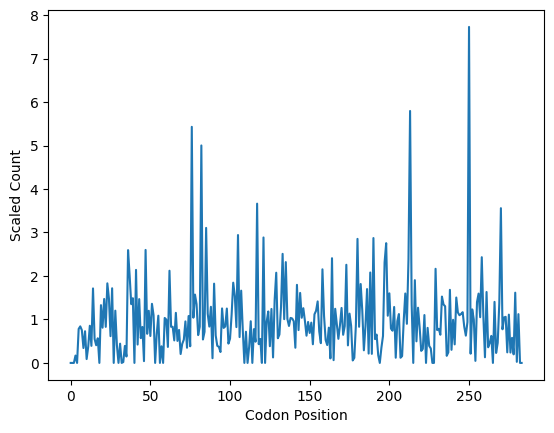

In [42]:
ribo_profile = predicted_elongation = model.predict_elongation(cds, profile=True)
# Plot the profile
x = range(len(ribo_profile))
plt.plot(x, ribo_profile)
plt.ylabel("Scaled Count")
plt.xlabel("Codon Position")
plt.show()

## Generating sequences
You might want to use the model to design some sequences for a given protein. I've implemented 2 ways to do this:
1. Generate a bunch of random sequences and score their predicted elongation times; you can sample from this distribution to obtain sequences with varied elongation times
2. Given the parameters of the model, generate the *mathematically optimal* coding sequence (either the fastest or slowest)

In [43]:
# AA sequence for Citrine
cit_seq = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLGYGLMCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSYQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

## Randomized Sequences

In [70]:
# First, let's generate 1000 random citrine sequences
sequences, scores = model.predict_random_speeds(cit_seq, 1000)

In [73]:
# Store the results of the above in a dataframe
scores_df = pd.DataFrame(zip(sequences, scores), columns=["seq", "score"])

quantiles  = [0, 0.33, 0.66, 1]
quantile_seqs, quantile_scores = [], []
for q in quantiles:
    quantile = scores_df["score"].quantile(q=q, interpolation="nearest")
    df_q = scores_df.loc[scores_df["score"] == quantile]
    quantile_seqs.append(df_q["seq"].item())
    quantile_scores.append(df_q["score"].item())
qdf = pd.DataFrame([quantile_seqs, quantile_scores, quantiles]).T
qdf.columns = ["seq", "score", "quantile"]
qdf

,seq,score,quantile
0,ATGTCGAAGGGTGAGGAATTGTTTACGGGCGTTGTCCCGATACTTG...,199.149026,0
1,ATGAGCAAAGGAGAAGAACTCTTTACGGGAGTCGTGCCAATTTTGG...,232.839681,0.33
2,ATGTCCAAGGGTGAGGAATTATTCACGGGTGTCGTTCCTATCCTGG...,242.413595,0.66
3,ATGTCGAAAGGAGAAGAGCTATTCACGGGCGTTGTGCCGATTCTCG...,274.482291,1


## Optimal Sequences
This takes ~5 min per sequence when I run it. Note that for larger models (e.g. -5 to +4 as opposed to -3 to +2), the time this takes scales dramatically! So it'd be best to put that into a script if you wish to do so.

In [ ]:
fastest_cit_seq = model.optimize_codons(cit_seq, fastest=True)
slowest_cit_seq = model.optimize_codons(cit_seq, fastest=False)
# Using these sequences, find their scores
fastscore = model.predict_elongation(fastest_cit_seq)
slowscore = model.predict_elongation(slowest_cit_seq)

## Plotting Scores

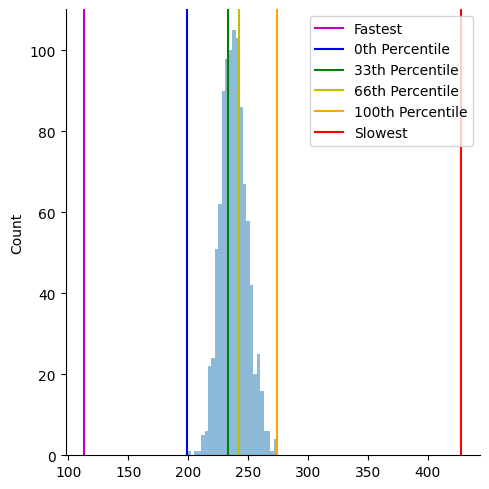

In [89]:
sns.displot(scores, edgecolor=None, alpha=0.5)
plt.axvline(fastscore, c='m', label="Fastest")
q_colors = ["b", "g", "y", "orange"]
for idx, quantile in enumerate(quantiles):
    plt.axvline(
        qdf.loc[qdf["quantile"] == quantile, "score"].item(),
        c=q_colors[idx], label=f"{int(quantile * 100)}th Percentile")

plt.axvline(slowscore, c='r', label='Slowest')
plt.legend()
# plt.title("Citrine first 20 AA")
plt.show()

# Using models trained using original iXnos code
It's possible to load an iXnos model trained using the original code into this new framework, and thus you're able to use all the functionality of my implementation on these models. You might want to do this if, for instance, you wanted to use iXnos models trained on yeast data by Rob (since I haven't trained any such models myself).

In [95]:
pklpath = "iXnos/expts/iwasaki/lasagne_nn/full_cod_n5p4_nt_n15p14_rep0/epoch70/weights.pkl"
model_orig = load_ixnos(pklpath, min_codon=-5, max_codon=4)
model_orig.eval()

iXnos(
  (layers): Sequential(
    (0): Linear(in_features=760, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [ ]:
# We can now use the same functions as above using this model. 
# For instance, predicting the total elongation time of the fastest seq from above:
model_orig.predict_elongation(fastest_cit_seq)

116.22415179014206